In [31]:
# do all the import stuff
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from scipy import signal
import numpy as np
import math

# import my modules
import sys
sys.path.append('/home/julian/dev/computer_vision_ws2015/')

import juvis as jv

Smila = np.array(Image.open('smila.png').convert('L'))
Factor = 0.5
size = (int(Smila.shape[1] * Factor), int(Smila.shape[0] * Factor))
Smila = jv.imresize(Smila, size)

# Introduction to Computer Vision
## continuous representation of images

$$I:{\rm I\!R}^2 \supset \Omega \rightarrow {\rm I\!R}, (x,y)\mapsto I(x,y)$$
Assumptions:
* $I$ is inferable
* $\Omega$ is a connected space and limited


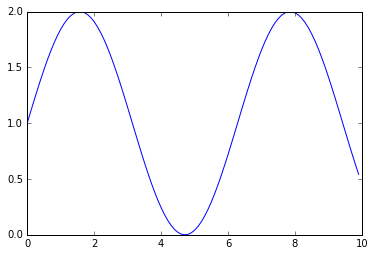

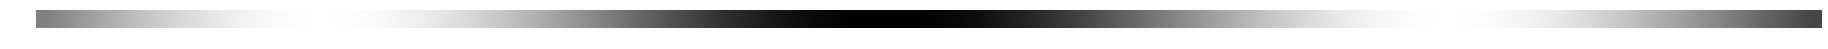

In [2]:
x = np.arange(0, 10, 0.1)
y = np.sin(x) + 1
plt.plot(x, y)
plt.show()
y = y.reshape(1,100)
jv.paint_mats([y])

## Gradient

* Edges are stong local changes of intensity
* Local changes of intensity are described through the gradient

$$\bigtriangledown I(x,y)=\begin{bmatrix} \frac{d}{dx}I(x,y)\\ \frac{d}{dy}I(x,y) \end{bmatrix}$$

Problem: Image is discrete, how to differentiate?

Naive:
$$\frac{d}{dx}I(x,y)\approx I(x+1,y)-I(x,y)$$
$$\frac{d}{dy}I(x,y)\approx I(x,y+1)-I(x,y)$$

Problem:
Only direct neighbors are taken into consideration, thus, when there is strong noise, we might get issues.

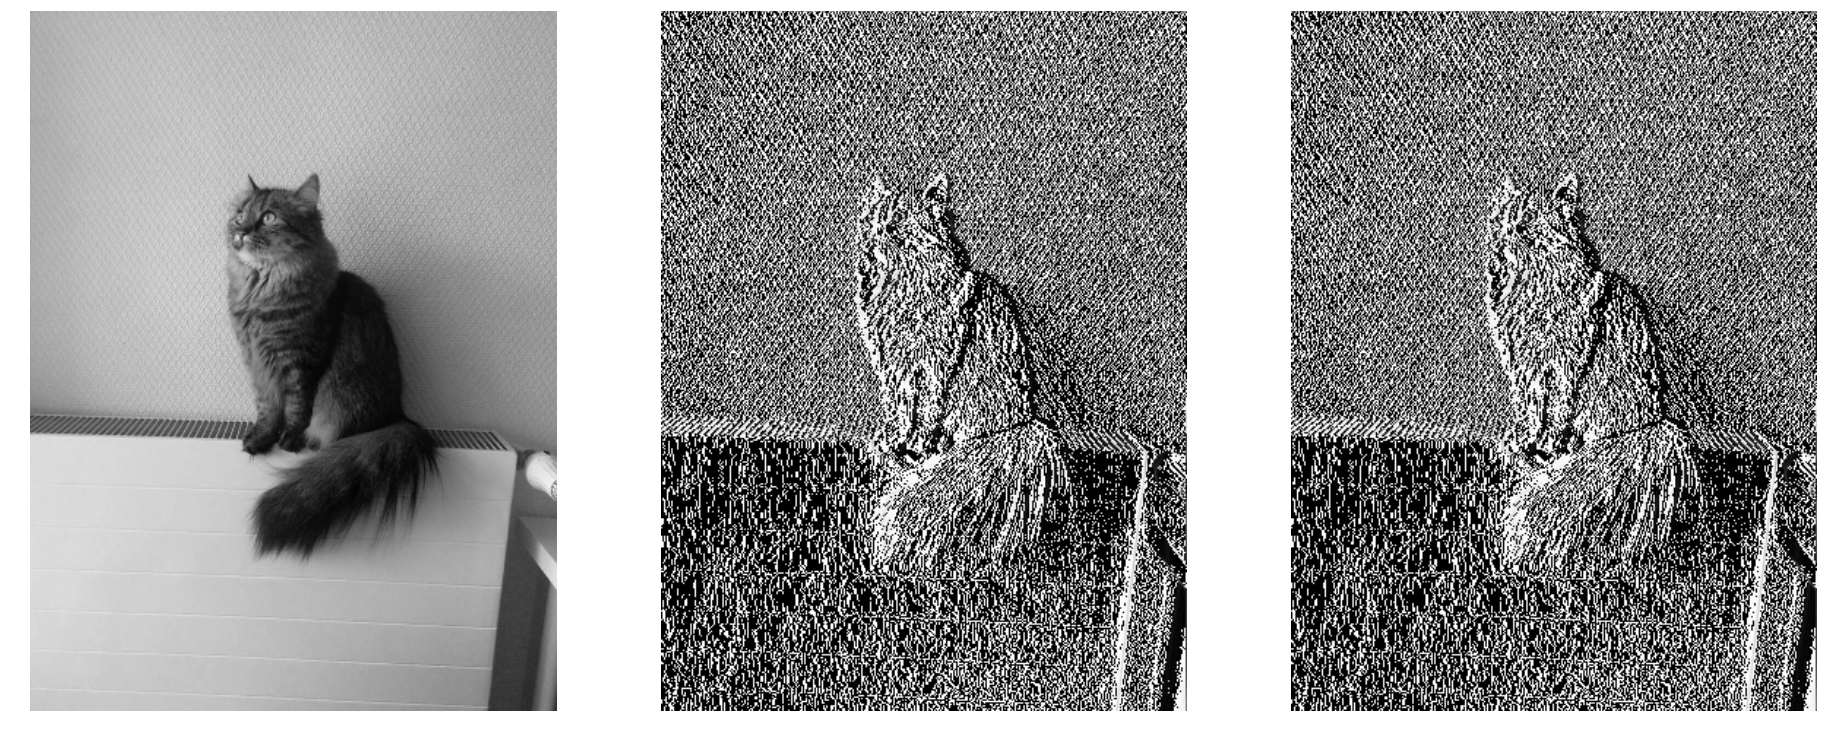

In [3]:
A = Smila.copy()
# naive derivation
AplusX = np.roll(A,-1,axis=1)
AplusY = np.roll(A,-1)
Ax = AplusX - A
Ay = AplusY - A

jv.paint_mats([A,Ax, Ay])

To solve this issue we need to interpolate the discrete Signal $f[x]=S\{f(x)\}$ ($S\{f(x)\})$ is the function to get discrete values from a function $f(x)$) back to a continuous signal $f(x)$ 

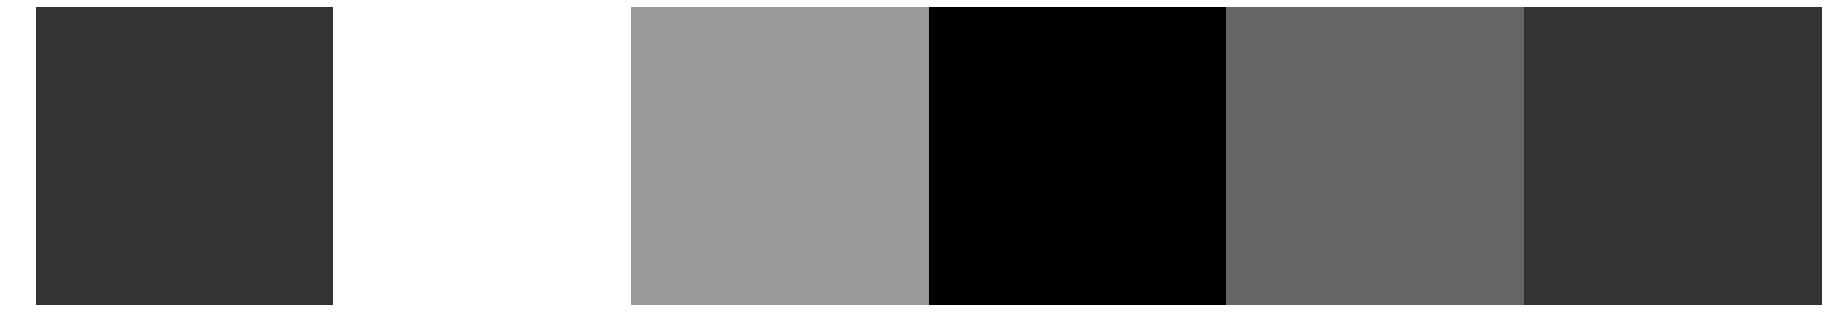

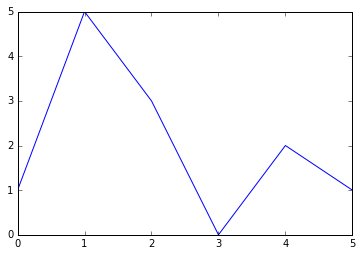

In [15]:
# discrete signal
D = np.array([1,5,3,0,2,1])
D = D.reshape(1,len(D))
jv.paint_mats([D], interpolation="nearest")

x = np.arange(0, D.shape[1], 1)
y = D.flatten()
plt.plot(x, y)
plt.show()

put a function $h(x)$ at the discrete points and sum their values.

The interpolated signal is a convolution ($*$) of the discrete points with the interpolation filter $h(x)$

$$f(x)\approx\sum_{k=-\infty}^{\infty} f[k]h(x-k)=:f[x]*h(x)$$

### Interpolation filter

#### gaussian
* Discrete signal: $f[x]=S\{f(x)\}$
* Continuous signal: $f(x)\approx f[x]*h(x)$
* Gaussian filter: $h(x)=g(x)=Ce^{\frac{-x^2}{2\sigma^2}}, C=\frac{1}{\sqrt{2\pi \sigma}}, \sigma=1$

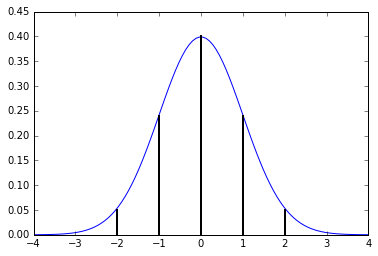

In [95]:
def g(x, sig):
    C = 1. / (math.sqrt(2*math.pi)*sig)
    return C * np.exp(-np.power(x,2.) / (2 * np.power(sig,2.)))
    
x = np.linspace(-4, 4, 100)
G = g(x, 1)
plt.plot(x,G)

plt.plot([-2,-2], [0,.05], 'k-', lw=2)
plt.plot([-1,-1], [0,.24], 'k-', lw=2)
plt.plot([0,0], [0,.4], 'k-', lw=2)
plt.plot([1,1], [0,.24], 'k-', lw=2)
plt.plot([2,2], [0,.05], 'k-', lw=2)

plt.show()


#### ideal interpolation filter

* cardinal sine function: $h(x)=sinc(x) = \frac{\sin{\pi x}}{\pi x}, sinc(0):=1$
* $f[x]*h(x)=f(x)$

sinc is $1$ at the given entry and $0$ at all other discrete points

The derivate of the $sinc$ function, $sinc'$, flattens out slowly so many neighbors have to be considered for the gradient.

The derivate of $gauss$ function, on the other hand, flattens out quickly and is, thus, better for derivation.

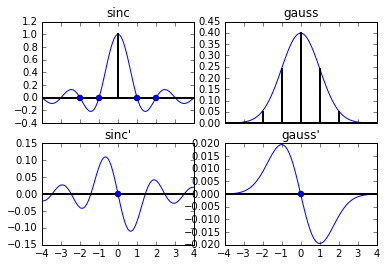

In [100]:
def sinc(x):
    return np.sin(math.pi * x)/ (math.pi * x)

x = np.linspace(-4, 4, 100)
S = sinc(x)

f, ax = plt.subplots(2,2, sharex=True, sharey=False)

ax0 = ax[0][0]
ax1 = ax[1][0]

ax2 = ax[0][1]
ax3 = ax[1][1]

ax0.plot(x,S)

ax0.plot([-4,4], [0,0], 'k-', lw=2)
ax0.plot([0,0], [0,1], 'k-', lw=2)

ax0.plot([-2,-1,1,2],[0,0,0,0], 'bo')
ax0.set_title('sinc')

ax1.plot(x,np.gradient(S))
ax1.plot([-4,4], [0,0], 'k-', lw=2)
ax1.plot([0],[0], 'bo')
ax1.set_title('sinc\'')

# gaussian
ax2.plot(x,G)

ax2.plot([-2,-2], [0,.05], 'k-', lw=2)
ax2.plot([-1,-1], [0,.24], 'k-', lw=2)
ax2.plot([0,0], [0,.4], 'k-', lw=2)
ax2.plot([1,1], [0,.24], 'k-', lw=2)
ax2.plot([2,2], [0,.05], 'k-', lw=2)
ax2.plot([-4,4], [0,0], 'k-', lw=2)
ax2.set_title('gauss')

ax3.plot(x,np.gradient(G))
ax3.plot([-4,4], [0,0], 'k-', lw=2)
ax3.plot([0],[0], 'bo')
ax3.set_title('gauss\'')

plt.show()

### Derivate a discrete Image

Algorithm:
* Reconstruct a continuous signal
* derivate this continuous signal
* discretize the derivated image

Convolution:
$$f[x]*h(x)=\sum_{k=-\infty}^{\infty}f[k]h(x-k)$$

if we derive the convolution against $x$, we note that only the $h$ function contains an $x$ and is thus affected:

Derivation:
$$f'(x)\approx \frac{d}{dx}(f[x]*h(x))=f[x]*h'(x)$$
$$= \sum_k f[k]*h'(x-k)$$

Turn it back into a discrete function:
$$f'[x] = f[x]*h'[x] = \sum_{k} f[k]*h'[x-k]$$

Change of index: $k \leftrightarrow x-k$

$$= \sum_{k=-\infty}^{\infty} f[x-k]h'[k]$$

### 2D filter

$$h(x,y):=g(x)g(y)$$

* 2D-Reconstruction:
$$ I(x,y)\approx I[x,y]*h(x,y)=\sum_{k=-\infty}^{\infty}\sum_{l=-\infty}^{\infty}I[x][y]g(x-k)g(y-l)$$

* derivation in x
$$\frac{d}{dx}I(x,y)\approx I[x,y]*(\frac{d}{dx}h(x,y)) = \sum_{k=-\infty}^{\infty}\sum_{l=-\infty}^{\infty}I[k,l]g'(x-k)g(y-l) $$

* discrete derivation in x (after change of index occured):
$$ S\{\frac{d}{dx}I(x,y)\}= I[x,y]*g'[x]*g[y]= \sum_{k=-\infty}^{\infty}\sum_{l=-\infty}^{\infty} I[x-k,y-l]g'[k]g[l] $$

A practical consideration: we need to approximate the infinite sum with few sums.

#### approximating

We need to answer the question of how we can choose a weight $C$ for the gaussian filter $g(x)=Ce^{\frac{-x^2}{2\sigma^2}}$

* interpolated signal: $$f(x)\approx \sum_{k=-\infty}^{\infty}f[k]g(x-k)$$

* scanned interpolated signal: $$f[x]\approx \sum_{k=-\infty}^{\infty}f[x-k]g[k]$$

* approximate with finite sum:
$$f[x]\approx \sum_{k=-n}^{n}f[x-k]g[k]$$

* the finite approximation of $f[x]$ is a weighted sum of $f[x-n],...,f[x+n]$ with weights $g[n],...,g[-n]$

* we choose normalisation constant $C$ so that all weights add up to $1$
$$C=\frac{1}{\sum_{-n\leq k \leq n}e^{\frac{-k^2}{2\sigma^2}}}$$

$$g[k]=Ce^{\frac{-k^2}{2\sigma^2}}$$

$$\sum_{k=-n}^{n}g[k]=1 $$

## Sobel filter

* Approximation of 
$$ S\{\frac{d}{dx}I(x,y)\}=I[x,y]*g'[x]*g[y]=\sum_{k=-/infty}^{/infty}\sum_{l=-/infty}^{/infty}I[x-k,y-l]g'[k]g[l]$$

* with finite sum:
$$ \sum_{k=-1}^{1}\sum_{k=-1}^{1}I[x-k,y-l]g'[k]g[l] $$

* we can now calculate the normalisation factor: $C=\frac{1}{1+2e^{-\frac{1}{2\sigma^2}}}$